In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('data/data.csv')

In [26]:
data.head()

,Season,Cultivar,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
0,1,NEO 760 CE,1,58.80,15.20,98.2,177.80,1.81,5.2,152.20,3232.82
1,1,NEO 760 CE,2,58.60,13.40,102.0,195.00,1.85,7.2,141.69,3517.36
2,1,NEO 760 CE,3,63.40,17.20,100.4,203.00,2.02,6.8,148.81,3391.46
3,1,NEO 760 CE,4,60.27,15.27,100.2,191.93,1.89,6.4,148.50,3312.58
4,1,MANU IPRO,1,81.20,18.00,98.8,173.00,1.75,7.4,145.59,3230.99


# Data cleaning & preprocessing

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      320 non-null    int64  
 1   Cultivar    320 non-null    object 
 2   Repetition  320 non-null    int64  
 3   PH          320 non-null    float64
 4   IFP         320 non-null    float64
 5   NLP         320 non-null    float64
 6   NGP         320 non-null    float64
 7   NGL         320 non-null    float64
 8   NS          320 non-null    float64
 9   MHG         320 non-null    float64
 10  GY          320 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 27.6+ KB


As stated in the dataset documentation there are no missing values and all the columns have the right data type.

In [13]:
data.describe()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
count,320.000000,320.000000,320.000000,320.0000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,1.500000,2.500000,68.386781,15.4650,59.088313,135.085844,2.290844,4.071656,168.322313,3418.553794
std,0.500783,1.119785,8.958194,3.0243,20.068187,60.494529,0.840116,1.474531,19.625566,503.003602
min,1.000000,1.000000,47.600000,7.2000,20.200000,47.800000,0.940000,0.400000,127.060000,1538.230000
25%,1.000000,1.750000,62.950000,13.6000,44.350000,95.052500,2.000000,3.000000,153.845000,3126.611552
50%,1.500000,2.500000,67.200000,15.6000,54.500000,123.000000,2.280000,3.800000,166.150000,3397.276724
75%,2.000000,3.250000,74.347500,17.3300,71.220000,161.350000,2.480000,5.000000,183.182500,3708.262931
max,2.000000,4.000000,94.800000,26.4000,123.000000,683.400000,14.860000,9.000000,216.000000,4930.000000



From the table above we can see that the maximum number of grains per plant (NGP) and number of legumes per plant (NGL) is very far from the top 75%.

In [5]:
float_cols = data.select_dtypes(include='float64').columns

mean_and_median = {}
for col in float_cols:
    mean_and_median[col] = {'mean':data[col].mean(), 'median':data[col].median()}
    
mean_and_median

{'PH': {'mean': 68.38678124999998, 'median': 67.2},
 'IFP': {'mean': 15.465000000000003, 'median': 15.6},
 'NLP': {'mean': 59.08831250000001, 'median': 54.5},
 'NGP': {'mean': 135.08584375, 'median': 123.0},
 'NGL': {'mean': 2.29084375, 'median': 2.28},
 'NS': {'mean': 4.07165625, 'median': 3.8},
 'MHG': {'mean': 168.3223125, 'median': 166.15},
 'GY': {'mean': 3418.5537941749994, 'median': 3397.276724}}

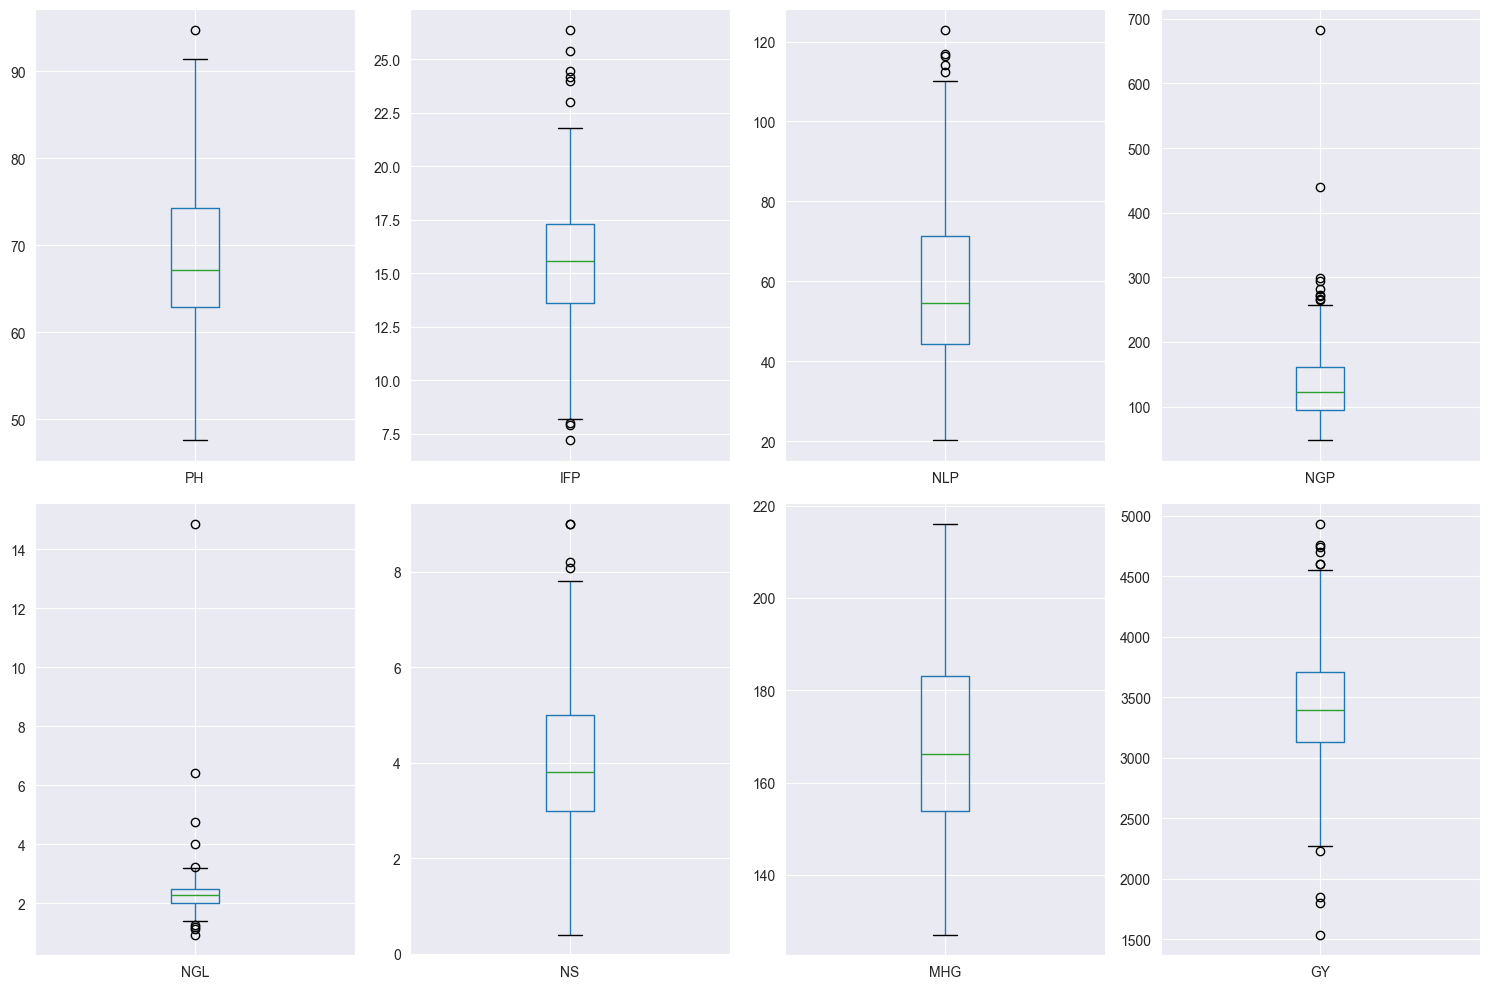

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cnt = 0
for i in range(2):
    for j in range(4):
        data.boxplot(column=float_cols.tolist()[cnt], ax=axs[i,j])
        cnt += 1
fig.tight_layout()
plt.show()

The boxplots comfirm outliers existence.

<Axes: xlabel='NGP', ylabel='Count'>

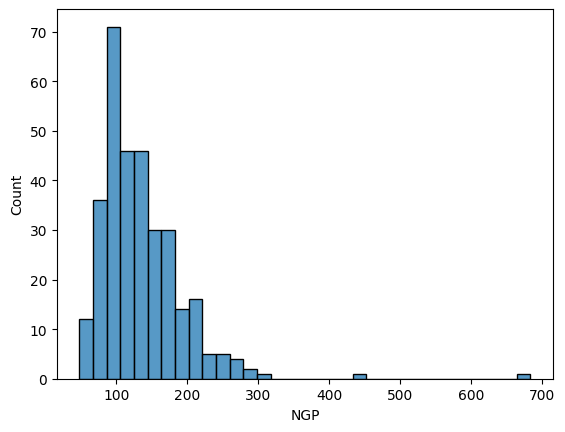

In [43]:
sns.histplot(data, x='NGP')

<Axes: xlabel='NGL', ylabel='Count'>

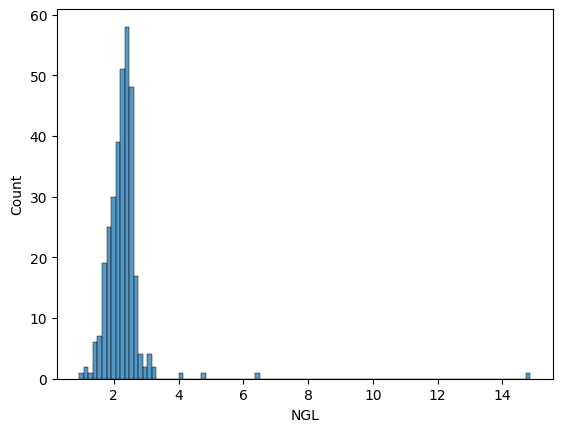

In [44]:
sns.histplot(data, x='NGL')

<Axes: >

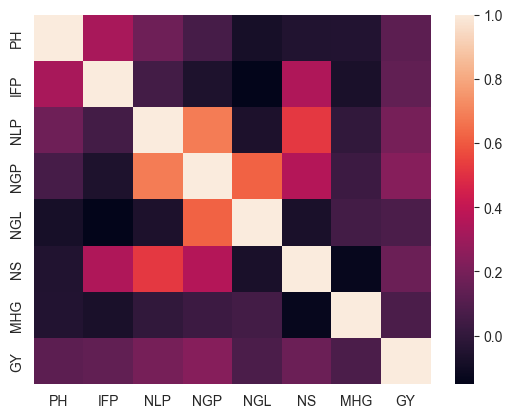

In [7]:
sns.heatmap(data[float_cols].corr())

<Axes: xlabel='NGP', ylabel='NGL'>

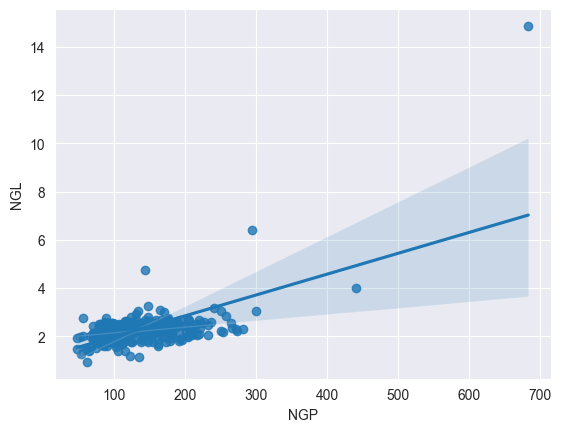

In [10]:
sns.regplot(data, x='NGP', y='NGL')

# Feature engineering

# Exploratory Data Analysis

<Axes: xlabel='NGP', ylabel='Count'>

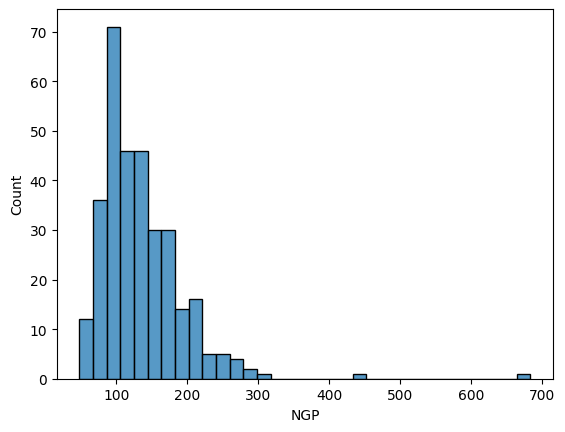